# <center> Learning the topology of a Bayesian Network from a database of cases using the K2 algorithm 
    
## Aidin Attar - 2048654 
## Ema Baci - 2050726

### Table of contents:
- [Libraries](#lib)
- [1. Introduction](#intro)
- [2. Algorithm implementation in R](#algo)
    - [2.1 - Algorithm](#algo1)
    - [2.2 - Scoring function](#score1)
    - [2.3 - Logarithmic scoring function](#score2)
- [3. Finding the most probable belief-network structure for a simple database](#db1)
- [4. Usage of the bnstruct package](#bnstruct)
    - [4.1 - Built-in K2 algorithm](#builtin)
    - [4.2 - User-provided K2 algorithm](#userprovided)
- [5. Application to other dabases](#other)
    - [5.1 - Analyse bnstruct with missing data](#missing)
    - [5.2 - CHILD database](#child)
    - [5.3 - ALARM database](#alarm)
- [6. Computation time](#comptime)
- [7. Conclusions](#conclusions)
- [Bibliography](#biblio)
    
### [Github Repo](https://github.com/emabaci/Advanced-Statistics-Project)

## Libraries<a class="anchor" id="lib"></a>

In [1]:
suppressMessages(library(IRdisplay))
suppressMessages(library(dplyr))
suppressMessages(library(bnlearn))
suppressMessages(library(combinat))
suppressMessages(library(bnstruct))
suppressMessages(library(qgraph))
suppressMessages(library(data.table))
suppressMessages(library(corrplot))
suppressMessages(library(ggplot2))

## 1. Introduction<a class="anchor" id="intro"></a>

The task of structure learning for Bayesian networks refers to learning the structure of the directed acyclic graph (DAG) from data. There are two major approaches for structure learning: score-based and constraint-based.

In this project we will use a score-based method: the score-based approach first defines a criterion to evaluate how well the Bayesian network fits the data, then searches over the space of DAGs for a structure achieving the maximal score. The score-based approach is essentially a search problem that consists of two parts: the definition of a score metric and the search algorithm.

The score based method used is the K2 algorithm, implemented in R language. This method was first introduced by Cooper and Hersokovits in [[2]](#2).

#### Assumptions for computing $P(B_s, D)$
* 1- The database variables, which we denote as Z, are discrete.
* 2- Cases occur independently, given a belief-network model.
* 3- There are no cases that have variables with missing values.
* 4- The likelihood function f(Bp|Bs) is uniform.

The scheme reported below is an example of a belief-network structure $B_s$, where the nodes representes our variables and the archs representes the dependencies.

A Bayesian belief-network structure, $B_s$, is augmented by a set of probabilities, $B_p$, to form a Bayesian belief network B. Thus, B =($B_s$, $B_p$).

Example of Bs

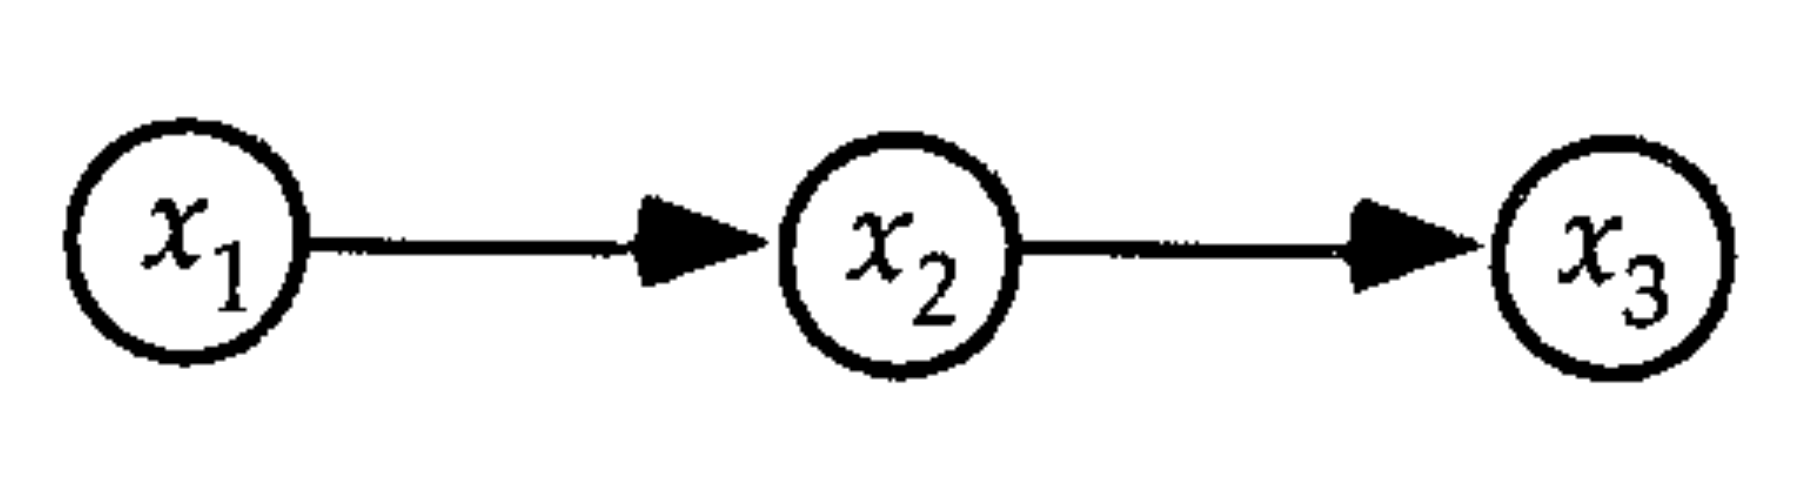

Example of Bp: for each node in a belief-network structure, there is a conditional-probability function that relates 
this node to its immediate predecessors (parents) and if a node has no parents, then a prior-probability function 
is provided.

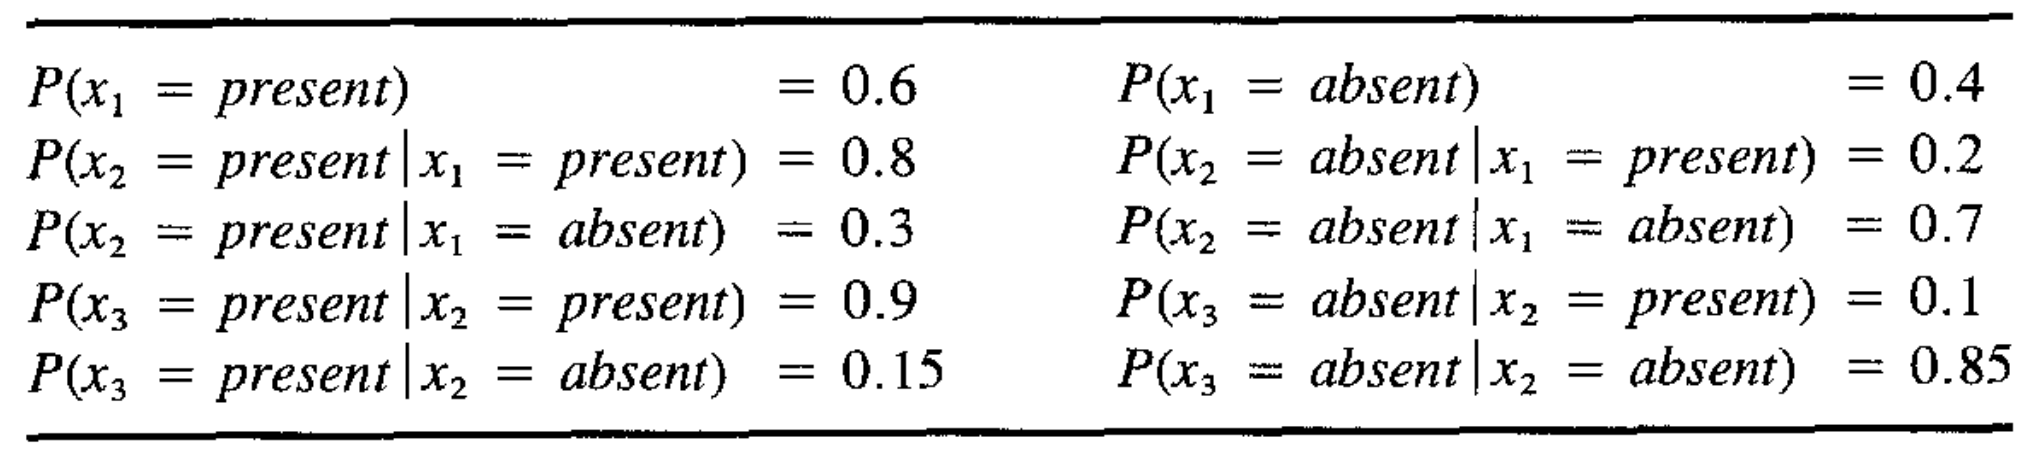

In [2]:
h = 70
cat('Example of Bs')
display_png(file="figures/Belief_network_ex.png", width = 3*h, height =h ) 
cat('Example of Bp: for each node in a belief-network structure, there is a conditional-probability function that relates 
this node to its immediate predecessors (parents) and if a node has no parents, then a prior-probability function 
is provided.')
display_png(file="figures/prob_assignment.png", width = 10*h, height =2*h )  

#### Notation
* $m$: number of cases in D
* $n$: number of variables in D
* $Z = \{x\}_i$, i = 1,..,n set of variables
* $r_i$: number of possible value assigned to $x_i$
* $v_i = \{v_{i1},...,v_{ir_i}\}$ : possible value assignments to $x_i$
* $parents \space of\space x_i$: immediate predecessors of $x_i$
* $\pi_i$: set of parents related to $x_i$
* $q_i$ = number of possible value assigned to $\pi_i$ 
* $w_i = \{ w_{ij}, j = 1,..,r_j\}$ unique instantiation of $\pi_i$ relative to D. 
* $N_{ijk}$: number of cases in D in which variable $x_i$ has the value $v_{ik}$ and $\pi_i$ is instantiated as $w_{ij}$


## 2. Algorithm implementation in R<a class="anchor" id="algo"></a>

Heuristically the algorithm works as follows:
    - It takes a database as an ordered list of nodes such that,a priori, all structures are considered equally likely
    - For every node the algorithm begins making an assumption that there is no parent and perform a greedy-search adding parents-nodes that increase the score of the netwotk
    - When the addition of no single parent can increase the probability the algorithm stops and passes to the following node

### 2.1 Algorithm<a class="anchor" id="algo1"></a>
A pseudo-code is provided in [[2]](#2) and [[3]](#3) and we used it to implement out version of the algorithm:
```Python

    1. procedure K2;
    2. {Input: A set of n nodes, an ordering on the nodes, an upper bound u on the
    3.         number of parents a node may have, and a database D containing m cases.}
    4. {Output: For each node, a printout of the parents of the node.}
    5. for i:= 1 to n do
    6.   𝜋𝑖  := Ø;
    7.   P_old := f(i, 𝜋i); 
    8.   OKToProceed := true;
    9.   while OKToProceed and |𝜋i| < u do
    10.     let z be the node in Pred(xi) - 𝜋i that maximizes f(i, 𝜋i Ս {z});
    11.     P_new := f(i, 𝜋i Ս {z});
    12.     if P_new > P_old then
    13.       P_old := P_new;
    14.       𝜋i := 𝜋i Ս {z};
    15.     else OKToProceed := false;
    16.   end {while};
    17.   write('Node:', xi, 'Parent of xi:', 𝜋i);
    18.  end {for};
    19. end {K2};
```

In [3]:
K2 <- function(data, order=c(1,2,3), max.parents=3, 
               cases.column=TRUE, f=score, 
               output.prob=TRUE, output.graph=TRUE) {
    '
    K2 algorithm to learn the topology of a Bayesian Network.

    Input:
        - data: data.frame with n+1 columns (the first one is the case column)
        - order: vector with the ordering of the nodes in data
        - max.parents: upper bound on the number of parents a node may have
        - cases.column: boolean, true if the dataframe has the column cases
        - f: function to call as score function: [score, score.log]
        - output.prob: boolean, true if you want to output the probabilities
    Output:
        - list with first element the score and second element the dag
    '
    # select columns in the right order
    if(cases.column){
        nodes       <- data[, order+1]
    }
    else{
        nodes       <- data[, order]
    }
    
    # number of nodes
    n           <- length(nodes)
    
    output.list <- list()
    g.nodes     <- names(nodes)
    dag         <- empty.graph(nodes=g.nodes)
    k2.score    <- 0

    for( i in 1:n ){
        # empty vector to store the parents of each node
        parents <- character()
        p.old   <- f(nodes[i], nodes[parents])
        ok.to.proceed <- TRUE
        pred_xi <- g.nodes[1:i-1]

        while(ok.to.proceed & length(parents)<max.parents){
            # create a list with the possible parent nodes to inspect
            unions      <- lapply(setdiff(pred_xi, parents), union, parents)
            
            new.parents <- unlist(unions[which.max(sapply(unions, function(x) f(nodes[i], nodes[x])))])
            p.new       <- f(nodes[i], nodes[new.parents])        

            if(p.new > p.old){
                p.old   <- p.new
                parents <- new.parents
                for (p in parents){
                    dag <- set.arc(dag, from=p, to=g.nodes[i])
                }
            }
            else{
                ok.to.proceed <- FALSE
            }
        }
        cat("Node: ", g.nodes[i], "\t-> Parents of ", g.nodes[i], ": ", parents,'\n')
        k2.score <- k2.score + p.old
    }
    
    if (output.prob){
        if(cases.column){
            set <- data.frame(apply(data[2:ncol(data)],c(1,2),as.character), stringsAsFactors = TRUE)
        }
        else{
            set <- data.frame(apply(data[1:ncol(data)],c(1,2),as.character), stringsAsFactors = TRUE)
        }
        print(bn.fit(dag, data = set, method = 'bayes'))
    }
    if(output.graph){
        qgraph(dag, nodeNames = g.nodes, layout = "spring",
               legend=FALSE, theme = "colorblind")#, title = "DAG")
    }

    output.list["score"] <- k2.score
    output.list["dag"] <- list(dag)
    return(output.list)
}

### 2.2 Scoring function<a class="anchor" id="score1"></a>

We want to find the belief-network structure $B_s$ that maximize $P(B_s|D)$. In general, there may be more than one such structure but we we assume to be one.

We know that for a generic $B_{s_j}$ structure, over the assumption above, we have:
\begin{equation}
P(B_{s_j}| D) = \frac{P(B_{s_j}, D)}{P(D)}
\end{equation}

where $P(D)$ is the sum  over all the possibile  $P(B_{s_j}, D)$ as the belief-network structure $B_s$ that we assume equally likely a priori varies:  $P(D) = \sum\limits_{B_{s_j}} P(B_{s_j}, D)$


Thus, finding $B_s$ that maximize the posterior $P(B_s|D)$ is equivalent to find the one that maximize  $P(B_{s_j}, D)$ that can be done just computing 

\begin{equation}
P(B_{s_j}, D) = P(B_s)\prod_{i=1}^{n}\prod_{j=1}^{q_i}\frac{(r_i -1)!}{(N_{ij} + r_i -1)!}\prod_{k=1}^{r_i}N_{ijk}!
\end{equation}

for every possibile $B_s$ that mean that, given n variables we have to compute $P(B_{s_j}, D)$   $2^{\frac{n(n-1)}{2}}$ times, therefore the time complexity is $O(m n^2 r 2^n)$
that should be computational demanding for bigger datasets so we will implement an heuristic method instead.

To compute the probability we will use the following formula:

\begin{equation}
f(i, \pi) = \prod_{j=1}^{q_i}\frac{(r_i -1)!}{(N_{ij} + r_i -1)!}\prod_{k=1}^{r_i}N_{ijk}!
\end{equation}

In [4]:
score <- function(x.i, pi.i){
    '
    Function to compute the score: it represents the probability of the 
    database D given that the parents of x.i are pi.i

    Inputs:
        - x.i: list containing the i-th node of the database
        - pi.i: list of parents of node x.i

    Output:
        - probability of database given pi.i as parents of x.i
    '
    r.i <- length(unique(unlist(x.i)))
    # case without parents
    if(length(pi.i)==0){
        alpha <- table(x.i)
        N     <- sum(alpha)
        prob  <- factorial(r.i-1)/factorial(N+r.i-1)*prod(sapply(alpha,factorial))
    }

    # standard version with parents
    else{
        data  <- cbind(x.i,pi.i)
        alpha <- table(data)
        # recast in a matrix
        if (length(dim(alpha))>2){dim(alpha)<-c(r.i,length(alpha)/r.i)}
        # transpose
        alpha<-t(alpha)
        N.j <- rowSums(alpha)
        M.j <- apply(apply(alpha, c(1,2), factorial),1,prod)
        prob <- prod(apply(cbind(N.j,M.j),1, function(x) x[2]*factorial(r.i-1)/factorial(x[1] + r.i - 1)))
    }
    return(prob)
}

### 2.3 Logarithmic scoring function<a class="anchor" id="score2"></a>

In case of large databases the computation of the score becomes prohibitive: to avoid this kind of problems we implemented a logarithmic version of the scoring function, profiting the propriety of the logarithm:

$$
\log(a\cdot b) = \log(a) + \log(b)
$$

The score becomes:
\begin{equation}
L = \log f
\end{equation}

In [5]:
score.log <- function(x.i, pi.i){
    '
    Function to compute the logarithmic score: it represents the probability of the 
    database D given that the parents of x.i are pi.i

    Inputs:
        - x.i: list containing the i-th node of the database
        - pi.i: list of parents of node x.i

    Output:
        - probability of database given pi.i as parents of x.i
    '
    r.i <- length(unique(unlist(x.i)))
    # case without parents
    if(length(pi.i)==0){
        alpha <- table(x.i)
        N     <- sum(alpha)
        prob  <- lfactorial(r.i-1)-lfactorial(N+r.i-1)+sum(sapply(alpha,lfactorial))
    }

    # standard version with parents
    else{
        data  <- cbind(x.i,pi.i)
        alpha <- table(data)
        # recast in a matrix
        if (length(dim(alpha))>2){dim(alpha)<-c(r.i,length(alpha)/r.i)}
        # transpose
        alpha<-t(alpha)
        N.j <- rowSums(alpha)
        M.j <- apply(apply(alpha, c(1,2), lfactorial),1,sum)
        prob <- sum(apply(cbind(N.j,M.j),1, function(x) x[2]+lfactorial(r.i-1)-lfactorial(x[1] + r.i - 1)))
    }
    return(prob)
}

## 3. Finding the most probable belief-network structure for a simple database<a class="anchor" id="db1"></a>

The first task of the project is to use our implementation of the algorithm to infer the network structure and compare it to the results provided by Ruiz in [[3]](#3)



#### In our problem: 

* $m$ = 10
* $n$ = 3
* $Z$ = {$x_1$, $x_2$, $x_3$}
* $r_1$ = $r_2$ = $r_3$ = 2
* $v_i = (v_{1i},...,v_{ir_i})$ = $(v_{i1},v_{i2})$=(0,1) 
* $q_1$ = $q_2$ = $q_3$ = 2
* $w_i = (w_{i1},...,w_{iq_i})$ = $(w_{i1},w_{i2})$=(0,1) 

In [6]:
# input of the dataset
case  <- 1:10
x1    <- c(1,1,0,1,0,0,1,0,1,0)
x2    <- c(0,1,0,1,0,1,1,0,1,0)
x3    <- c(0,1,1,1,0,1,1,0,1,0)

D <- data.frame(case, x1, x2, x3)
D

case,x1,x2,x3
<int>,<dbl>,<dbl>,<dbl>
1,1,0,0
2,1,1,1
3,0,0,1
4,1,1,1
5,0,0,0
6,0,1,1
7,1,1,1
8,0,0,0
9,1,1,1


Node:  x1 	-> Parents of  x1 :   
Node:  x2 	-> Parents of  x2 :  x1 
Node:  x3 	-> Parents of  x3 :  x2 

  Bayesian network parameters

  Parameters of node x1 (multinomial distribution)

Conditional probability table:
   0   1 
0.5 0.5 

  Parameters of node x2 (multinomial distribution)

Conditional probability table:
 
   x1
x2          0         1
  0 0.7727273 0.2272727
  1 0.2272727 0.7727273

  Parameters of node x3 (multinomial distribution)

Conditional probability table:
 
   x2
x3           0          1
  0 0.77272727 0.04545455
  1 0.22727273 0.95454545



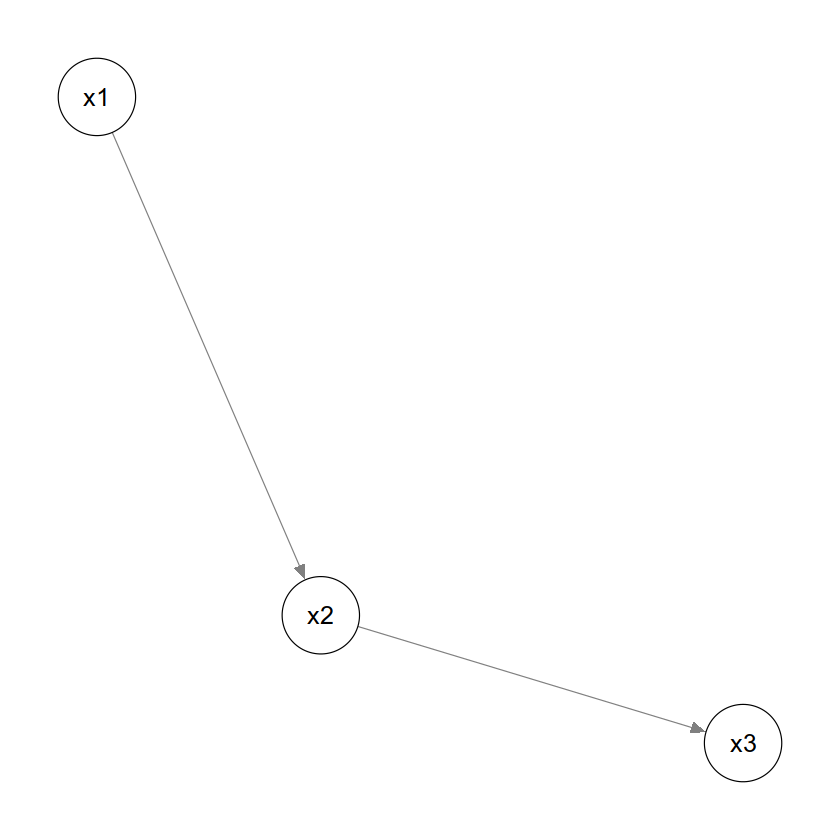

In [7]:
network<-K2(D)

The obtained network is the same as the results of Ruiz

Due to its structure, the algorithm is sensitive to the initial ordering given as input, for completeness we report below the results obtained for each combination of the 3 variables

Node:  x1 	-> Parents of  x1 :   
Node:  x2 	-> Parents of  x2 :  x1 
Node:  x3 	-> Parents of  x3 :  x2 
Node:  x1 	-> Parents of  x1 :   
Node:  x3 	-> Parents of  x3 :  x1 
Node:  x2 	-> Parents of  x2 :  x3 
Node:  x3 	-> Parents of  x3 :   
Node:  x1 	-> Parents of  x1 :  x3 
Node:  x2 	-> Parents of  x2 :  x3 
Node:  x3 	-> Parents of  x3 :   
Node:  x2 	-> Parents of  x2 :  x3 
Node:  x1 	-> Parents of  x1 :  x2 
Node:  x2 	-> Parents of  x2 :   
Node:  x3 	-> Parents of  x3 :  x2 
Node:  x1 	-> Parents of  x1 :  x2 
Node:  x2 	-> Parents of  x2 :   
Node:  x1 	-> Parents of  x1 :  x2 
Node:  x3 	-> Parents of  x3 :  x2 


X123,X132,X312,X321,X231,X213
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-19.92268,-20.76997,-20.7418,-19.89451,-19.92268,-19.92268


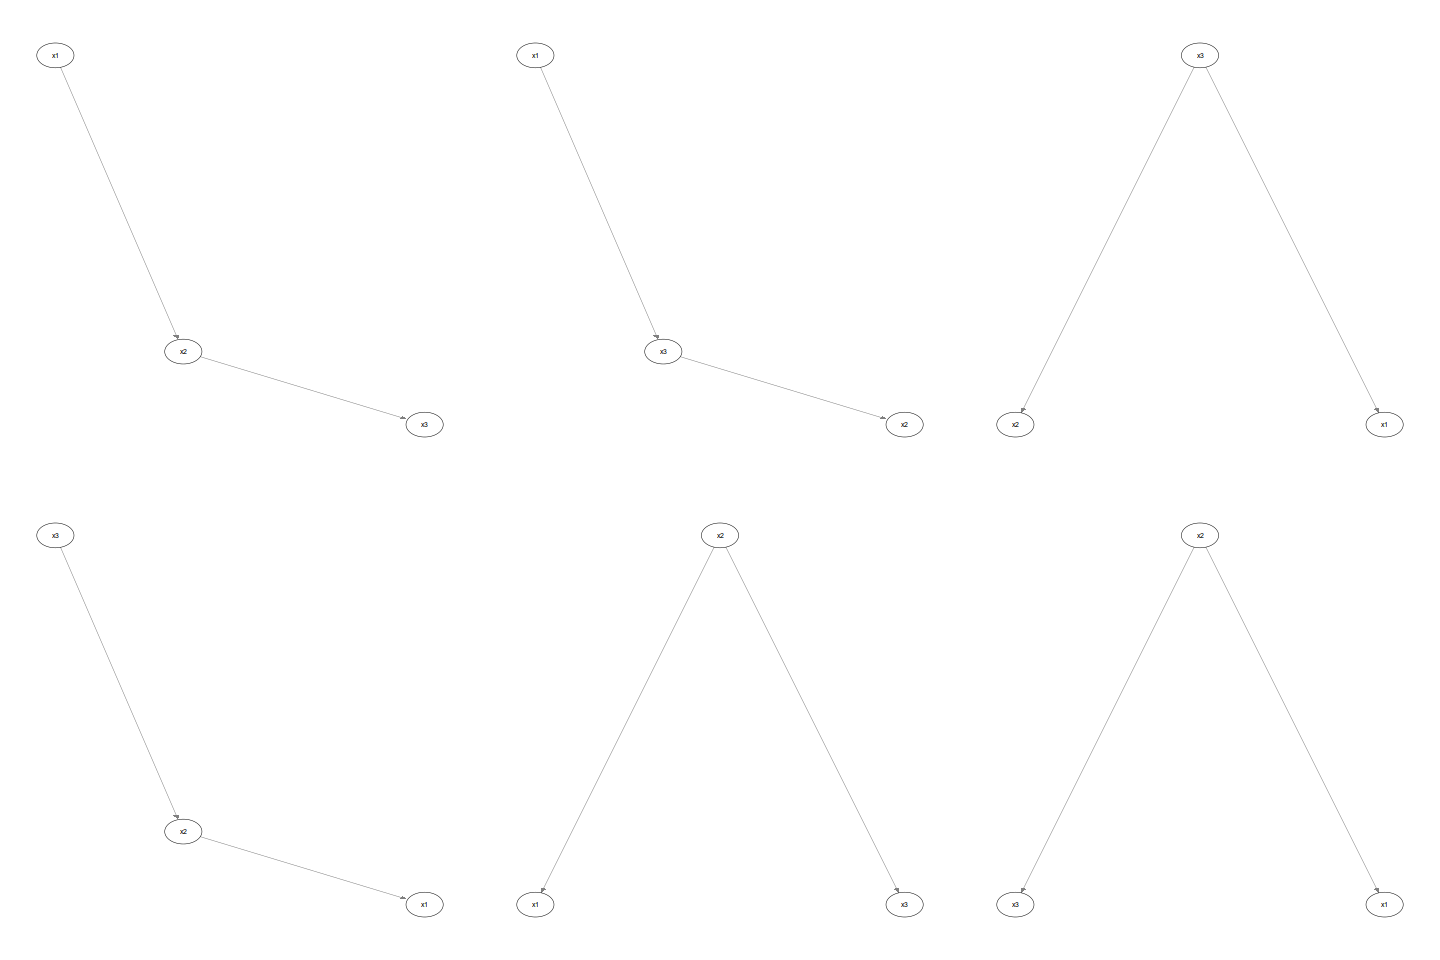

In [8]:
comb.scores <- function(data, from=1, to=3, plot.graph=FALSE){
    orders <- permn(1:3)
    scores <- list()
    dag    <- list()
    
    if(plot.graph) par(mfrow=c(2, 3))
    
    for(i in seq_along(orders)){
        k2.res    <- K2(data, order = unlist(orders[i], use.names=FALSE), f=score.log,output.prob = FALSE, 
                        output.graph=FALSE)
        
        scores[i] <- k2.res$score
        if(plot.graph){
            dag <- k2.res$dag
            
            qgraph(dag, nodeNames = names(D), layout = "spring", grous = D,
                   legend=FALSE, borders = TRUE, theme = "colorblind", esize=1)

        }
    }
    names(scores) <- sapply(orders, paste0, collapse="")
    
    return(as.data.frame(scores))
}

options(repr.plot.width=12, repr.plot.height=8)
options(warn=-1)
comb.scores(D, plot.graph=TRUE)

## 4 Usage of the bnstruct package<a class="anchor" id="bnstruct"></a>
In the following section we compare our results with the ones obtained using the bnstruct that is a R package for Bayesian  Network Structure Learning from Data with Missing Values using the 'hc' algoritm and the 'k2' scoring function, then we implemented the K2 algorithm inside the bnstruct package.

The bnstruct package provides objects and methods for learning the structure and parameters of the network in various situations, such as in presence of missing data, for which it is possible to perform imputation (guessing the missing values, by looking at the data). The package also contains methods for learning using the Bootstrap technique. Finally, bnstruct, has a set of additional tools to use Bayesian Networks, such as methods to perform inference and interventions.

### 4.1 - Built-in K2 algorithm (bnlearn)<a class="anchor" id="builtin"></a>


  Bayesian network parameters

  Parameters of node x1 (multinomial distribution)

Conditional probability table:
   0   1 
0.5 0.5 

  Parameters of node x2 (multinomial distribution)

Conditional probability table:
 
   x1
x2          0         1
  0 0.7727273 0.2272727
  1 0.2272727 0.7727273

  Parameters of node x3 (multinomial distribution)

Conditional probability table:
 
   x2
x3           0          1
  0 0.77272727 0.04545455
  1 0.22727273 0.95454545


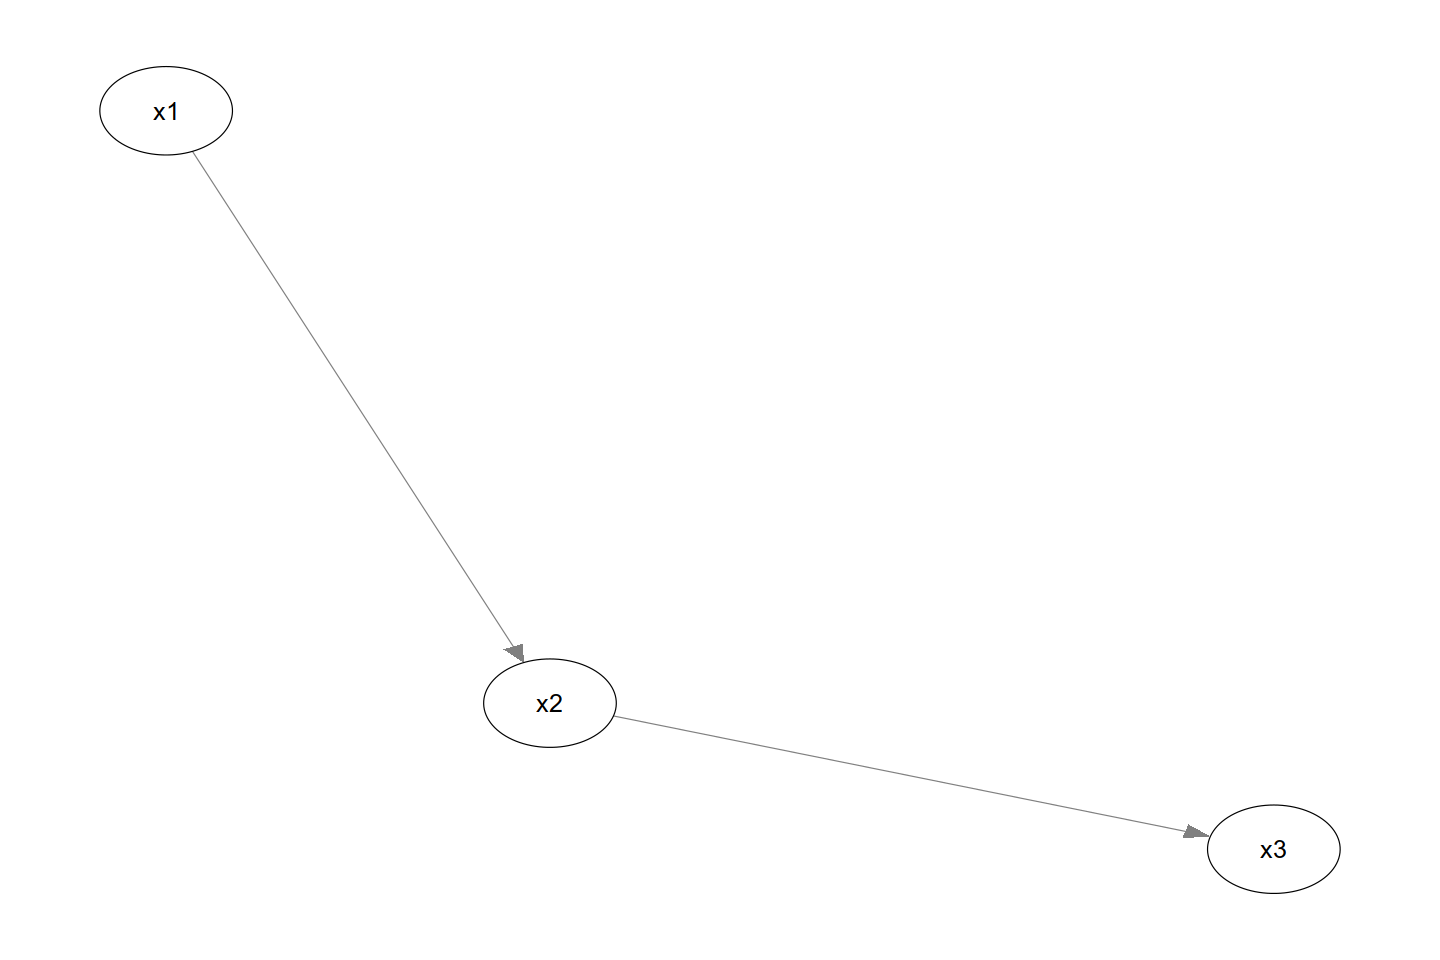

In [9]:
df.D <- data.frame(apply(D[2:4],c(1,2),as.character), stringsAsFactors = TRUE)

blacklist <- data.frame(from  = c('x2', 'x3', 'x3'), to = c('x1', 'x1', 'x2'))

net <- hc(df.D, score = 'k2', blacklist = blacklist, maxp = 2)

fit <- bn.fit(net, data = df.D, method = 'bayes')

fit
qgraph(net, palette="colorblind")

We also tried to use a built-in function of bnstruct. This library does not provide natively a k2 scoring: here the BDeu (Bayesian Dirichlet equivalent uniform) which is similar to the k2 scoring.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
Adjacency matrix:
   x1 x2 x3
x1  0  1  0
x2  0  0  1
x3  0  0  0

Conditional probability tables:$x1
x1
  1   2 
0.5 0.5 

$x2
   x2
x1          1         2
  1 0.7727273 0.2272727
  2 0.2272727 0.7727273

$x3
   x3
x2           1         2
  1 0.77272727 0.2272727
  2 0.04545455 0.9545455




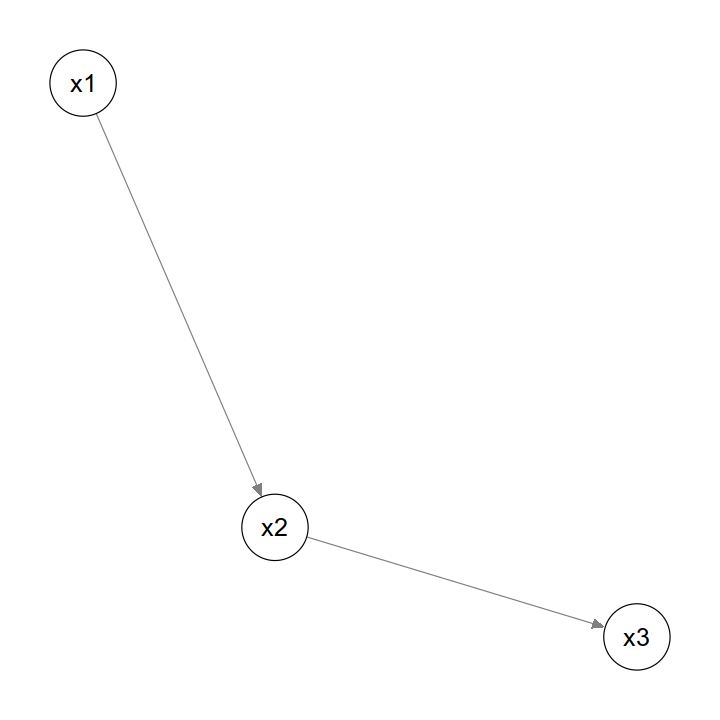

In [10]:
data <- D[2:4]
data.BND <- BNDataset(data = data,
                      discreteness = rep('d', ncol(data)),
                      variables = names(data),
                      node.sizes = c(2,2,2),
                      starts.from = 0)

bnet <- learn.network(data.BND, layering = c(1,2,3), scoring.func='BDeu', algo='hc')
print(bnet)

options(repr.plot.width=6, repr.plot.height=6)
plot(bnet, method='qgraph')

 As expected we obtained the same BN structure

### 4.2  User-provided K2 algorithm<a class="anchor" id="userprovided"></a>

We studied the structure of the learn.network functions and, based on them, implemented our script. In this way we defined a new method `learn.network.custom` which computes the best structure based on the K2 algorithm.

To implement our function we did the following:
* we downloaded the source code of the bnstruct package

```
wget https://cran.r-project.org/src/contrib/bnstruct_1.0.12.tar.gz
```
* extracted the compressed directory

```
tar -xvzf bnstruct_1.0.12.tar.gz
```

* Add the following line at the bottom of the "NAMESPACE" file:
```
exportMethods(learn.network.custom)
```

* Add to the file `AllGenerics.R`
```
setGeneric("learn.network.custom", function(x, algo='K2', scoring.func='default', 
                                            order=c(1,2,3), max.parents=2, f=score,initial.network=NULL) 
standardGeneric("learn.network.custom") )
```

* Add a file `K2.R` with the function below
* Build and reinstall the updated package
```
R CMD build bnstruct/
R CMD REMOVE bnstruct
R CMD INSTALL bnstruct_1.0.12.tar.gz
```



```r
setGeneric("learn.network.custom", function(x, algo='K2', scoring.func='default', 
                                            order=c(1,2,3), max.parents=2, f=score,initial.network=NULL) 
standardGeneric("learn.network.custom") )

#' @rdname learn.network.custom
#' @aliases learn.network.custom,BNDataset
setMethod("learn.network.custom",
          c("BNDataset"),
          function(x, algo='K2', scoring.func='default', 
                   order=c(1,2,3), max.parents=2, f=score,
                   initial.network=NULL){
              dataset <- x
              bn <- BN(dataset)
              
              # setup
              num.nodes(bn)  <- num.variables(dataset)
              node.sizes(bn) <- node.sizes(dataset)
              variables(bn)  <- variables(dataset)
              validObject(bn)

              node.sizes <- node.sizes(bn)
              num.nodes  <- num.nodes(bn)
              
              # get initial.network
              if (!is.null(initial.network)){
                  if (inherits(initial.network, "BN"))
                      init.net <- initial.network
                  else if (inherits(initial.network, "matrix")){
                    init.net      <- BN(dataset)
                    dag(init.net) <- initial.network
                    init.net      <- learn.params(init.net, dataset)
                  }
                  else if (inherits(initial.network, "character") &&
                           tolower(initial.network) == "random.chain")
                      init.net <- sample.chain(dataset)
                  else # string != "random.chain"
                      init.net <- NULL
                  if (!is.null(init.net))
                      validObject(init.net)
              }
              else
                  init.net <- NULL
              
              # select columns in the right order
              nodes <- as.data.frame(raw.data(data.BND))
              
              # number of nodes
              n <- length(nodes)

              # empty vector to store the parents of each node
              parents <- rep(NULL, 0)
    
              g.nodes <- names(nodes)
    
              dag.matrix <- matrix(0, nrow=n, ncol=n)

              for( i in 1:n ){
                  # empty vector to store the parents of each node
                  parents <- character()
                  p.old   <- f(nodes[i], nodes[parents])
                  ok.to.proceed <- TRUE
                  pred_xi <- g.nodes[1:i-1]

                  while(ok.to.proceed & length(parents)<max.parents){
                      # create a list with the possible parent nodes to inspect
                      unions      <- lapply(setdiff(pred_xi, parents), union, parents)

                      new.parents <- unlist(unions[which.max(
                          sapply(unions, function(x) f(nodes[i], nodes[x])))])
                      p.new       <- f(nodes[i], nodes[new.parents])

                      if(p.new > p.old){
                          p.old   <- p.new
                          parents <- new.parents
                      }
                      else{
                          ok.to.proceed <- FALSE
                      }
                  }
                  for (p in parents){
                      row <- grep(p, g.nodes)
                      dag.matrix[row, i] <- 1
                  }
              }
              dag(bn) <- dag.matrix
              bn <- learn.params(bn, dataset)
              return(bn)
          })
```

bnstruct :: Generating bootstrap samples with imputation ...

bnstruct :: Bootstrap samples generated.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
Adjacency matrix:
   x1 x2 x3
x1  0  1  0
x2  0  0  1
x3  0  0  0

Conditional probability tables:$x1
x1
  1   2 
0.5 0.5 

$x2
   x2
x1          1         2
  1 0.7727273 0.2272727
  2 0.2272727 0.7727273

$x3
   x3
x2           1         2
  1 0.77272727 0.2272727
  2 0.04545455 0.9545455




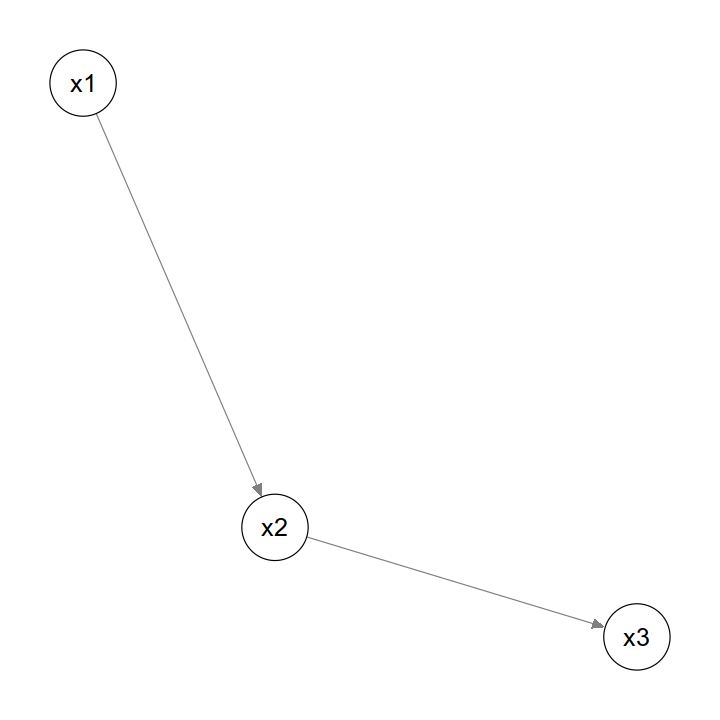

In [11]:
data.BND <- BNDataset(data = data,
                discreteness = rep('d', ncol(data)),
                variables = names(data),
                node.sizes = c(2,2,2),
                starts.from = 0)
data.BND <- bootstrap(data.BND, num.boots=100, imputation=TRUE)

bnet <- learn.network.custom(data.BND, scoring.func='default', algo='K2')
print(bnet)
plot(bnet, method = 'qgraph')


Again, we obtained the same BN structure.

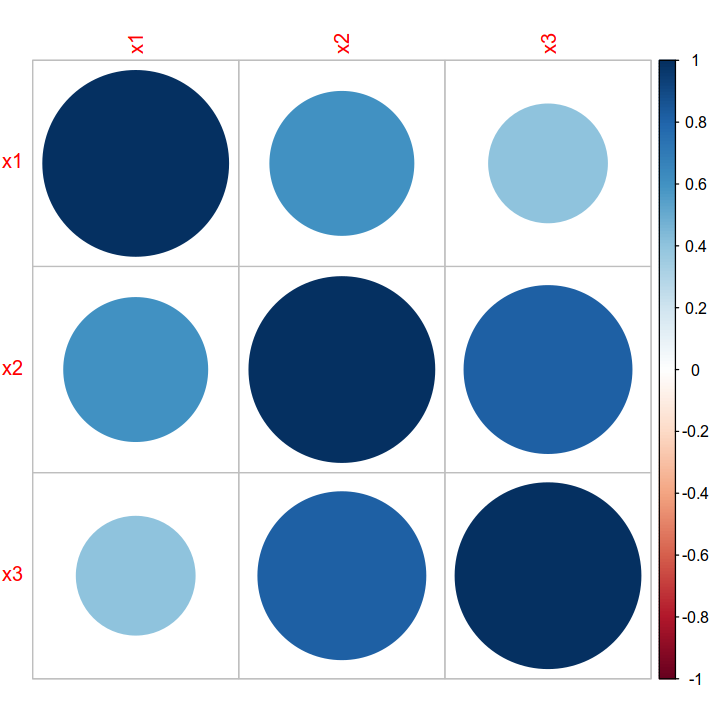

In [12]:
corrplot(cor(data), diag = TRUE)

## 5. Application to other dabases<a class="anchor" id="other"></a>

### 5.1 Analyse bnstruct with missing data <a class="anchor" id="missing"></a>
A dataset may contain various kinds of missing data, namely unobserved variables, and unobserved values for otherwise observed variables. We currently deal only with this second kind of missing data. The process of guessing the missing values is called imputation. We used the `impute` of `bnstruct` function to perform imputation.

Imputation is accomplished with the k-Nearest Neighbour algorithm. The number of neighbours to be used can be chosen specifying the `k.impute` parameter (default is `k.impute = 10`). Given that the parameter is highly dataset-dependant, we also include the `tune.knn.impute` function to assist the user
while choosing the best value for k.

Parameter learning is the operation that learns the conditional probabilities entailed by a network, given the data and the structure of the network. In `bnstruct` this is done by `learn.network` performing a Maximum-A-Posteriori (MAP) estimate of the parameters. It is possible to choose if using the raw or the impute dataset (use.imputed.data parameter), and to configure the
Equivalent Sample Size (ess parameter).

In [13]:
learned.net<- function(dataset){
    imp.dataset <- impute(dataset)
    df <- as.data.frame(imp.dataset@imputed.data)

    df <- data.frame(apply(df,c(1,2),as.character), stringsAsFactors = TRUE)
    net <- hc(df, score = 'k2', maxp = 2)
    fit <- bn.fit(net, data = df, method = 'bayes')

    qgraph(net, palette="colorblind", labels = variables(imp.dataset))   
    return (fit)
}

### 5.2 ASIA database<a class="anchor" id="asia"></a>
Small synthetic data set from Lauritzen and Spiegelhalter (1988) about lung diseases (tuberculosis, lung cancer or bronchitis) and visits to Asia.

The asia data set contains the following variables:

    - D (dyspnoea), a two-level factor with levels yes and no.
    - T (tuberculosis), a two-level factor with levels yes and no.
    - L (lung cancer), a two-level factor with levels yes and no.
    - B (bronchitis), a two-level factor with levels yes and no.
    - A (visit to Asia), a two-level factor with levels yes and no.
    - S (smoking), a two-level factor with levels yes and no.
    - X (chest X-ray), a two-level factor with levels yes and no.
    - E (tuberculosis versus lung cancer/bronchitis), a two-level factor with levels yes and no.


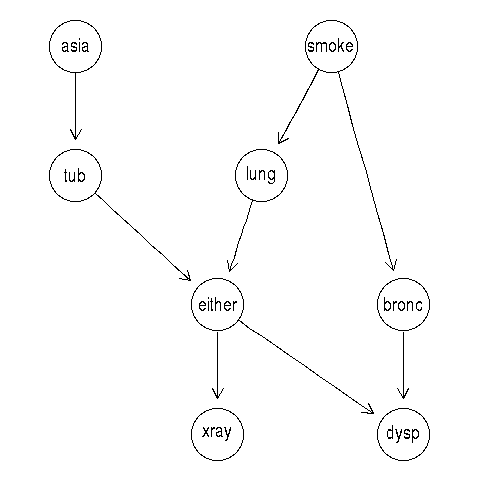

In [36]:
display_png(file="figures/ASIA.png", width = 10*h, height =10*h )

bnstruct :: performing imputation ...

bnstruct :: imputation finished.



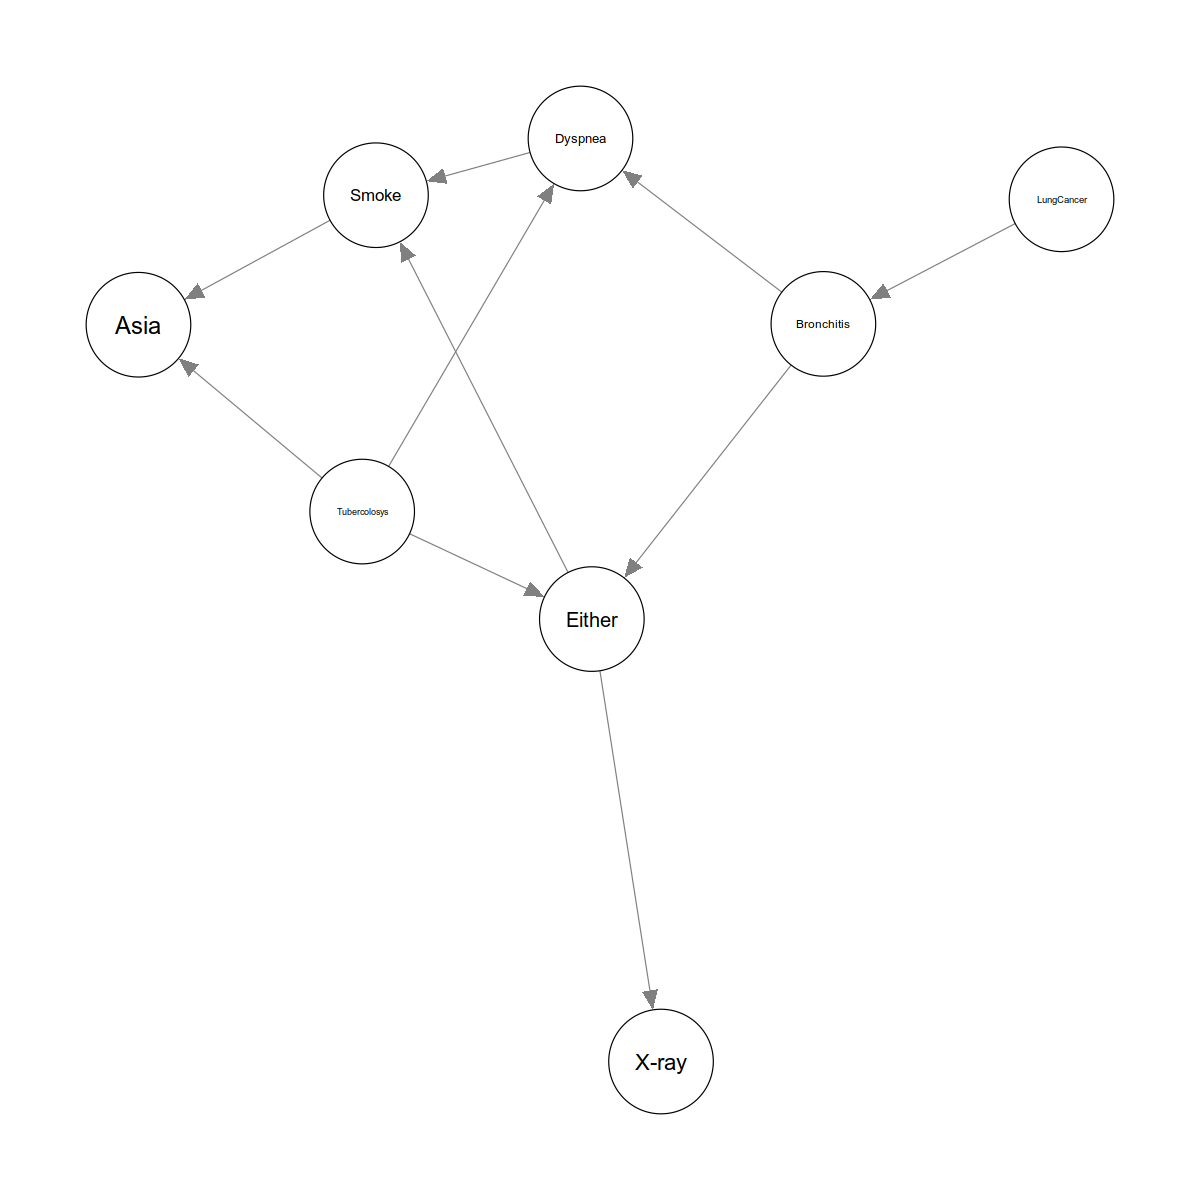

In [33]:
dataset <- asia()

options(repr.plot.width=10, repr.plot.height=10)
net1    <- learned.net(dataset)

bnstruct :: performing imputation ...

bnstruct :: imputation finished.



Node:  Asia 	-> Parents of  Asia :   
Node:  Tubercolosys 	-> Parents of  Tubercolosys :  Asia 
Node:  Smoke 	-> Parents of  Smoke :  Asia 
Node:  LungCancer 	-> Parents of  LungCancer :   
Node:  Bronchitis 	-> Parents of  Bronchitis :  LungCancer 
Node:  Either 	-> Parents of  Either :  Bronchitis Tubercolosys 
Node:  X-ray 	-> Parents of  X-ray :  Either 
Node:  Dyspnea 	-> Parents of  Dyspnea :  Either Smoke 


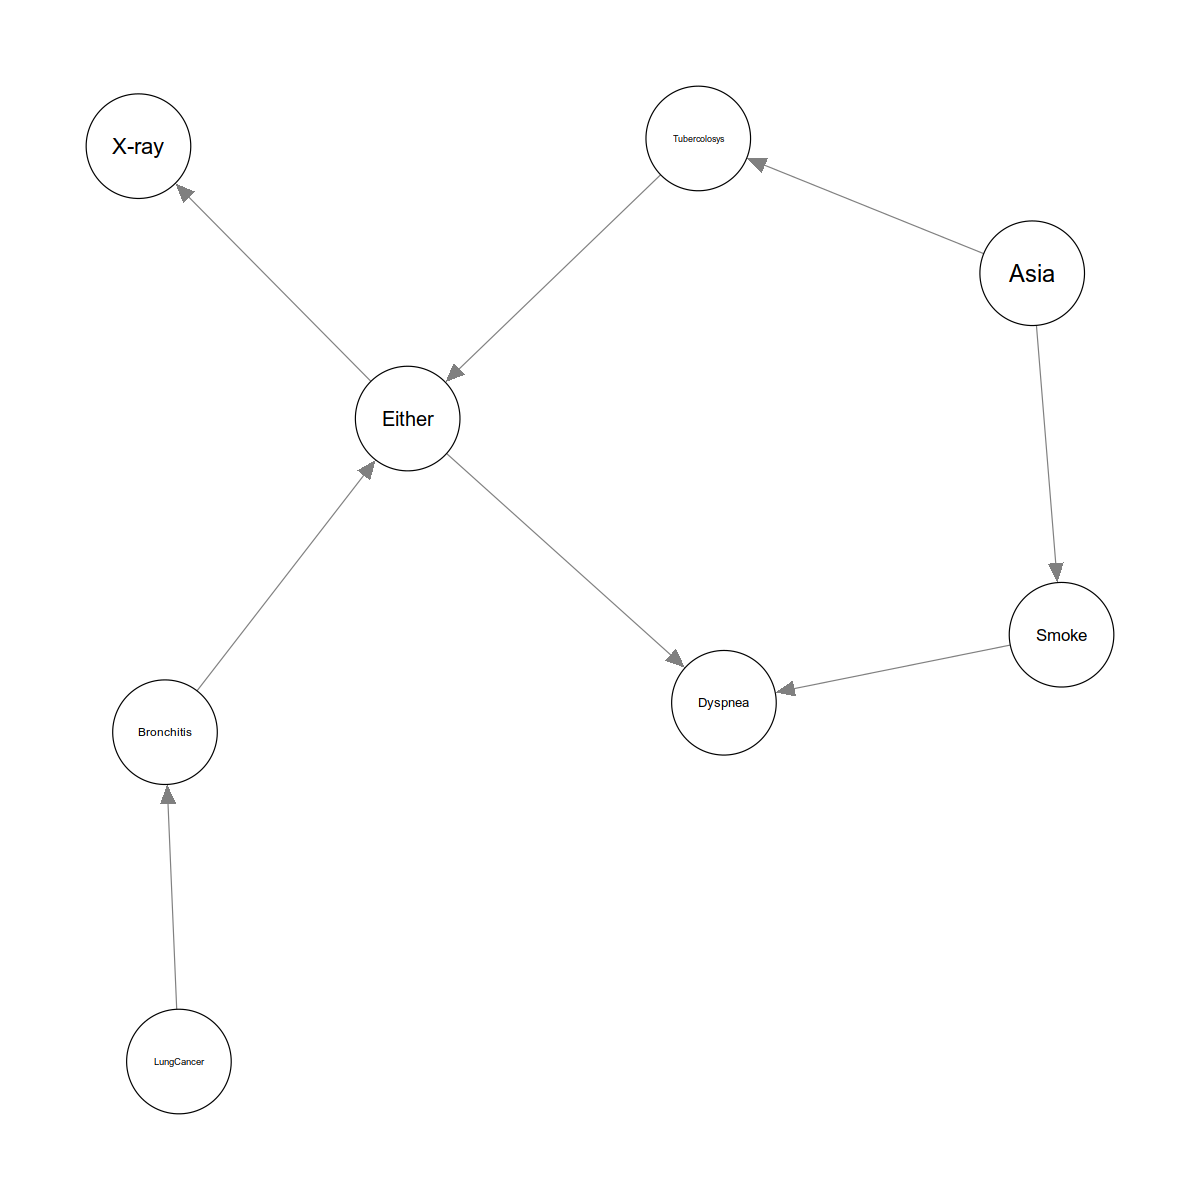

In [35]:
dataset      <- asia()
dataset      <- impute(dataset)
Asia        <- as.data.frame(imputed.data(dataset))
names(Asia) <- variables(asia())
net2 <-K2(data = as.data.frame(Asia), order = c(1:length(Asia)), max.parent=2, cases.column=FALSE, f=score.log,output.prob=FALSE)

### 5.3 CHILD database<a class="anchor" id="child"></a>

We now concentrate on the toy dataset Child, contained in the bnstruct library. It investigates the incidence and presentation of 6 possible diseases that would lead to a blue baby.
The node Disease includes six possible conditions, assumed mutually exclusive and exhaustive, that lead to particularly 'blue' babies. The graph represents, for example, that the level of oxygen in the lower body (LowerBodyO2) is directly related to the underlying level when breathing oxygen (HypoxiaInO2) and whether the hypoxia is equally distributed around the body (HypDistrib).

The number of nodes is equal to  and each node has a different cardinality.
As for what concerns the ordering of the nodes, it is taken from the image below:

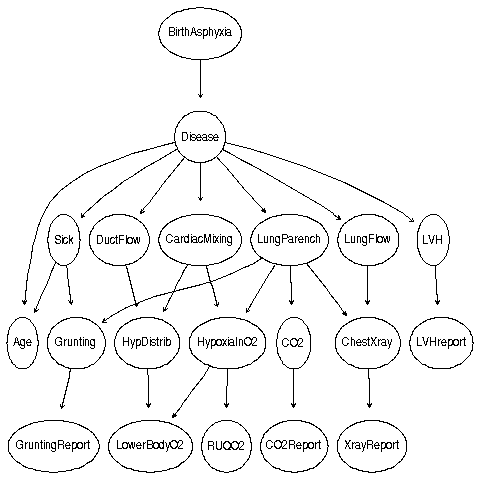

In [14]:
display_png(file="figures/CHILD.png", width = 10*h, height =10*h )

bnstruct :: performing imputation ...

bnstruct :: imputation finished.



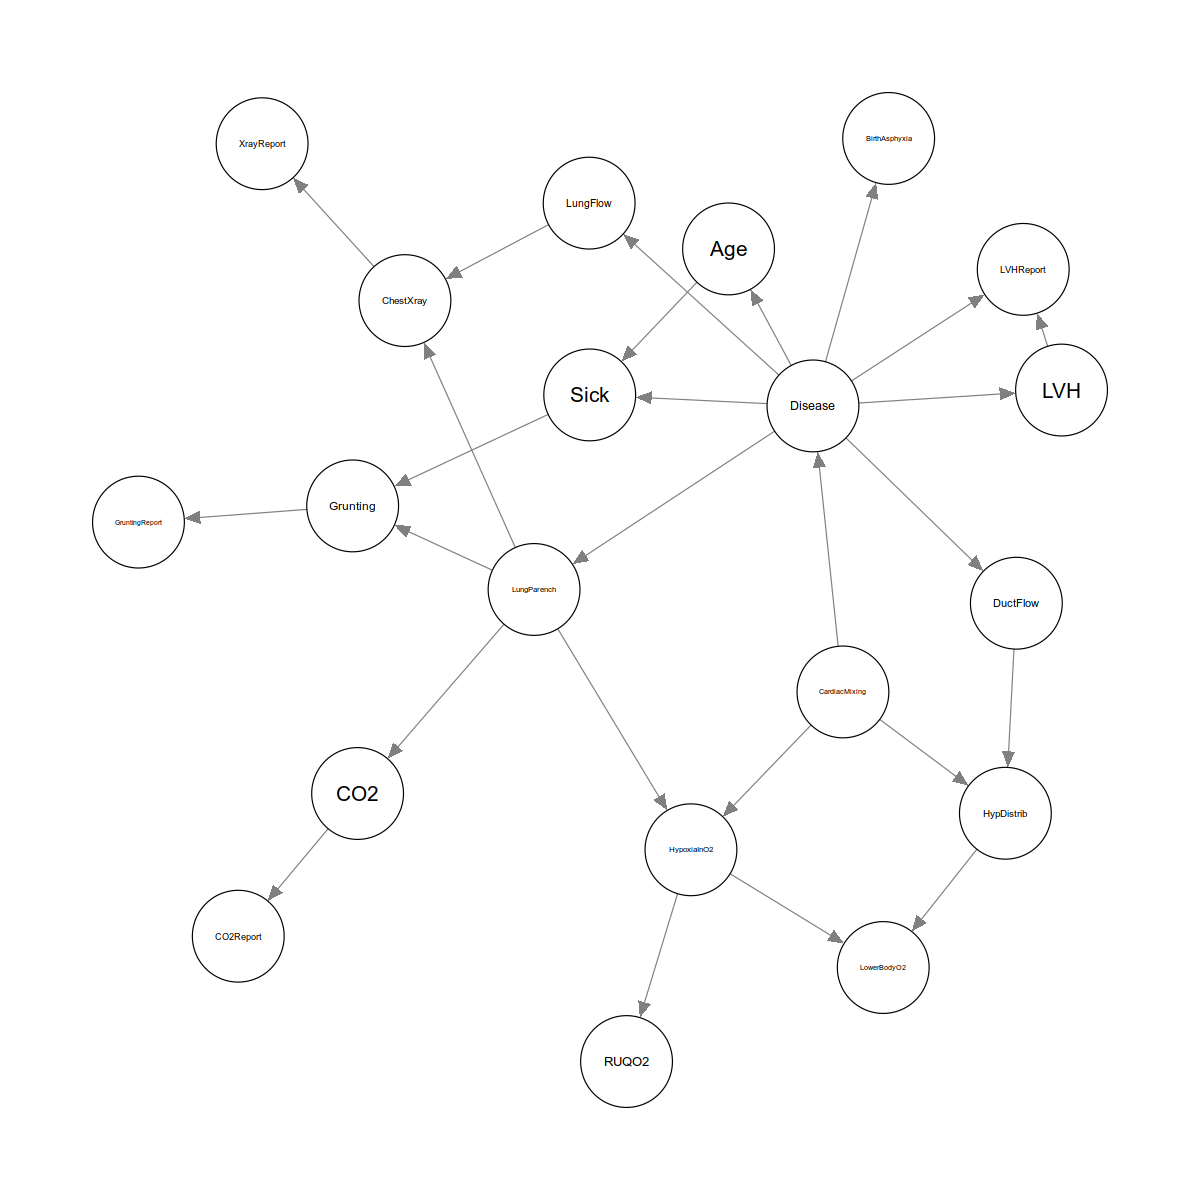

In [15]:
dataset <- child()

options(repr.plot.width=10, repr.plot.height=10)
net1    <- learned.net(dataset)


bnstruct :: performing imputation ...

bnstruct :: imputation finished.



Node:  BirthAsphyxia 	-> Parents of  BirthAsphyxia :   
Node:  Disease 	-> Parents of  Disease :  BirthAsphyxia 
Node:  Age 	-> Parents of  Age :  Disease 
Node:  LVH 	-> Parents of  LVH :  Disease 
Node:  DuctFlow 	-> Parents of  DuctFlow :  Disease 
Node:  CardiacMixing 	-> Parents of  CardiacMixing :  Disease 
Node:  LungParench 	-> Parents of  LungParench :  Disease 
Node:  LungFlow 	-> Parents of  LungFlow :  Disease 
Node:  Sick 	-> Parents of  Sick :  Age Disease 
Node:  HypDistrib 	-> Parents of  HypDistrib :  CardiacMixing DuctFlow 
Node:  HypoxiaInO2 	-> Parents of  HypoxiaInO2 :  LungParench CardiacMixing 
Node:  CO2 	-> Parents of  CO2 :  LungParench 
Node:  ChestXray 	-> Parents of  ChestXray :  LungParench LungFlow 
Node:  Grunting 	-> Parents of  Grunting :  Sick LungParench 
Node:  LVHReport 	-> Parents of  LVHReport :  Disease LVH 
Node:  LowerBodyO2 	-> Parents of  LowerBodyO2 :  HypDistrib HypoxiaInO2 
Node:  RUQO2 	-> Parents of  RUQO2 :  HypoxiaInO2 
Node:  CO2Repo

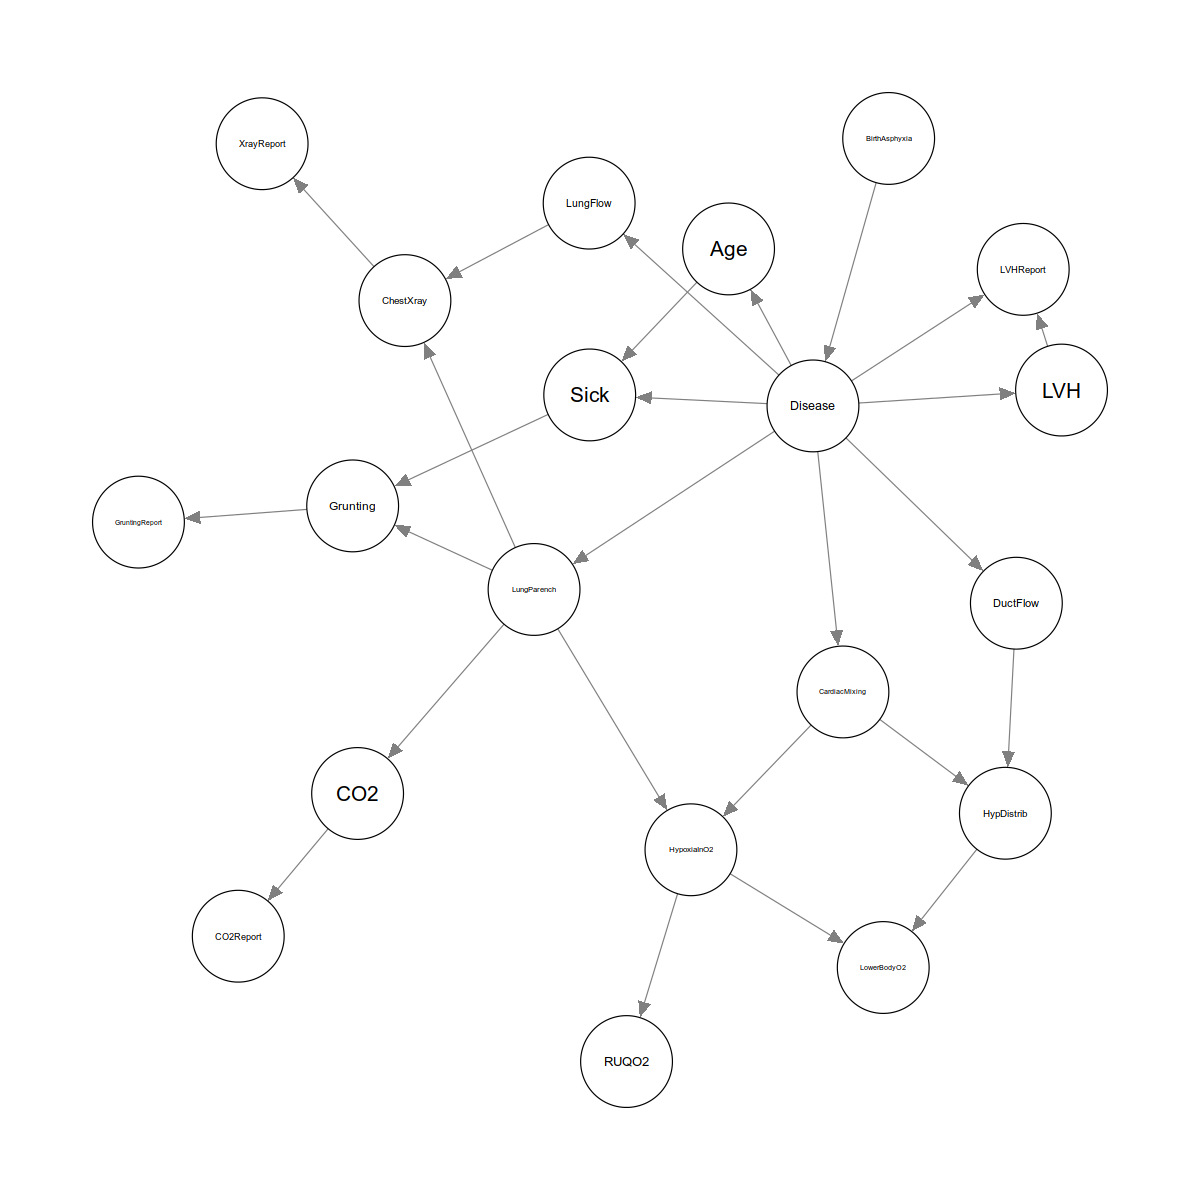

In [16]:
dataset      <- child()
dataset      <- impute(dataset)
Child        <- as.data.frame(imputed.data(dataset))
names(Child) <- variables(child())
net2 <-K2(data = as.data.frame(Child), order = c(1:20), max.parent=2, cases.column=FALSE, f=score.log,output.prob=FALSE)

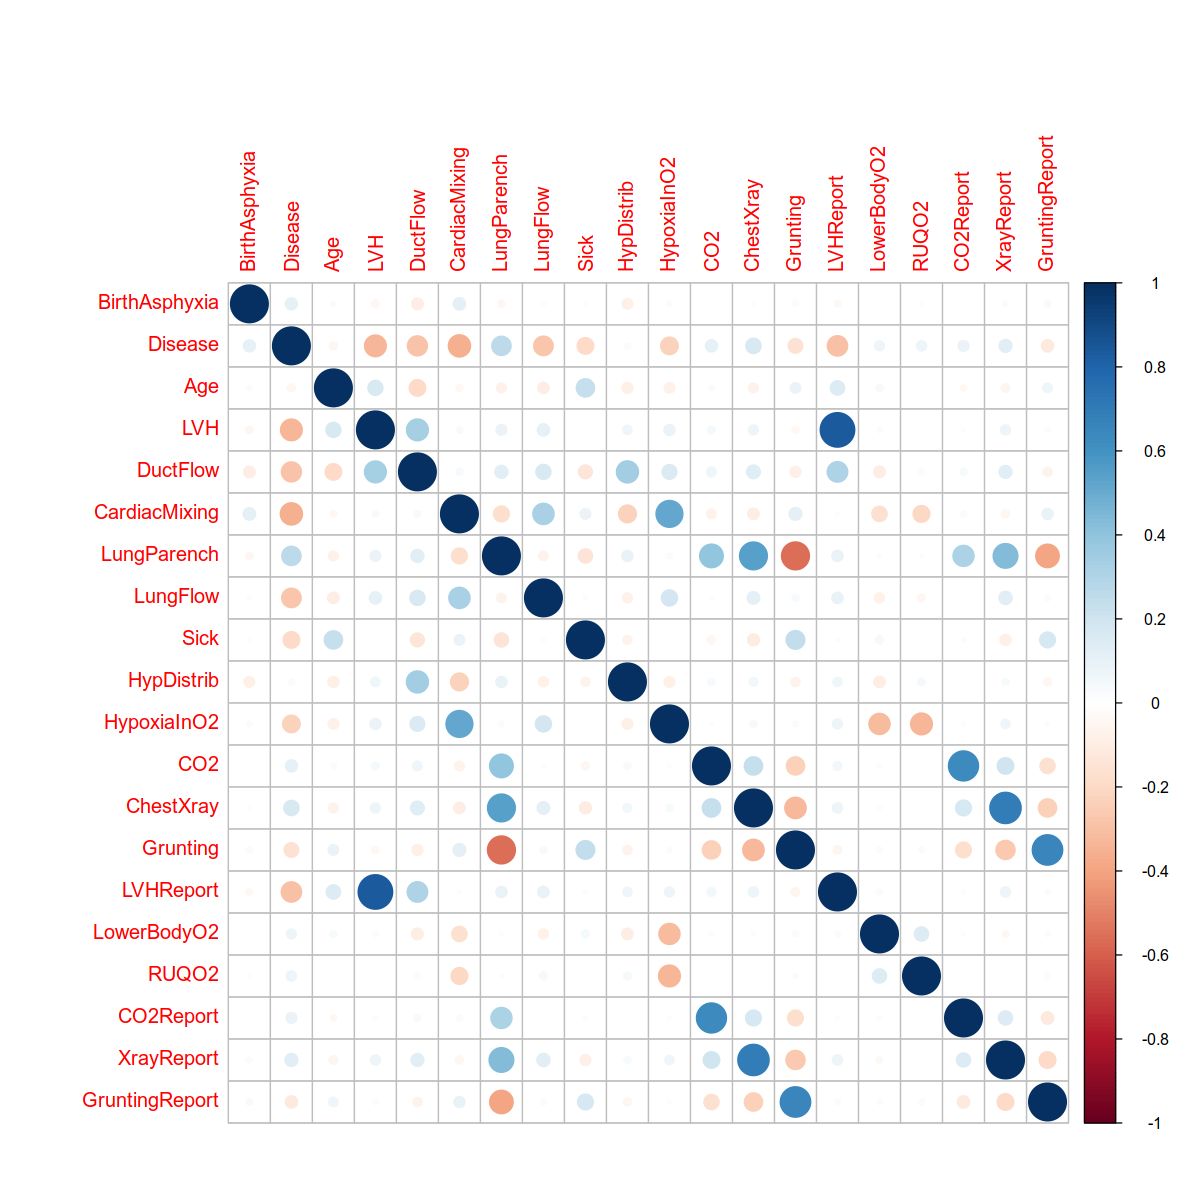

In [17]:
corrplot(cor(Child), diag = TRUE)

In [18]:
# non so cosa sia la roba sotto

In [19]:
# To retrieve the parameters
cpts(net1)

# update the probabilities with EM from the raw dataset,
# starting from the first network
engine <- InferenceEngine(net1)
results <- em(engine, dataset)
updated.engine  <- results$InferenceEngine
updated.dataset <- results$BNDataset

engine
results
#updated.engine
#updated.dataset

#net <- learn.network.custom(imp.dataset, scoring.func='K2')#, algo='default')



ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function ‘cpts’ for signature ‘"bn.fit"’


In [ ]:
plot(net1, method="qgraph")

### 5.3 ALARM database<a class="anchor" id="alarm"></a>

The ALARM ("A Logical Alarm Reduction Mechanism") is a Bayesian network designed to provide an alarm message system for patient monitoring.

The alarm data set contains the following 37 variables:

	- CVP (central venous pressure): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- PCWP (pulmonary capillary wedge pressure): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- HIST (history): a two-level factor with levels `TRUE` and `FALSE`
	- TPR (total peripheral resistance): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- BP (blood pressure): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- CO (cardiac output): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- HRBP (heart rate / blood pressure): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- HREK (heart rate measured by an EKG monitor): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- HRSA (heart rate / oxygen saturation): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- PAP (pulmonary artery pressure): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- SAO2 (arterial oxygen saturation): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- FIO2 (fraction of inspired oxygen): a two-level factor with levels `LOW` and `NORMAL`
	- PRSS (breathing pressure): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`
	- ECO2 (expelled CO2): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`
	- MINV (minimum volume): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`
	- MVS (minimum volume set): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- HYP (hypovolemia): a two-level factor with levels `TRUE` and `FALSE`
	- LVF (left ventricular failure): a two-level factor with levels `TRUE` and `FALSE`
	- APL (anaphylaxis): a two-level factor with levels `TRUE` and `FALSE`
	- ANES (insufficient anesthesia/analgesia): a two-level factor with levels `TRUE` and `FALSE`
	- PMB (pulmonary embolus): a two-level factor with levels `TRUE` and `FALSE`
	- INT (intubation): a three-level factor with levels `NORMAL`, `ESOPHAGEAL` and `ONESIDED`
	- KINK (kinked tube): a two-level factor with levels `TRUE` and `FALSE`
	- DISC (disconnection): a two-level factor with levels `TRUE` and `FALSE`
	- LVV (left ventricular end-diastolic volume): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- STKV (stroke volume): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- CCHL (catecholamine): a two-level factor with levels `NORMAL` and `HIGH`
	- ERLO (error `LOW` output): a two-level factor with levels `TRUE` and `FALSE`
	- HR (heart rate): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- ERCA (electrocauter): a two-level factor with levels `TRUE` and `FALSE`
	- SHNT (shunt): a two-level factor with levels `NORMAL` and `HIGH`
	- PVS (pulmonary venous oxygen saturation): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- ACO2 (arterial CO2): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`
	- VALV (pulmonary alveoli ventilation): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`
	- VLNG (lung ventilation): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`
	- VTUB (ventilation tube): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`
	- VMCH (ventilation machine): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`

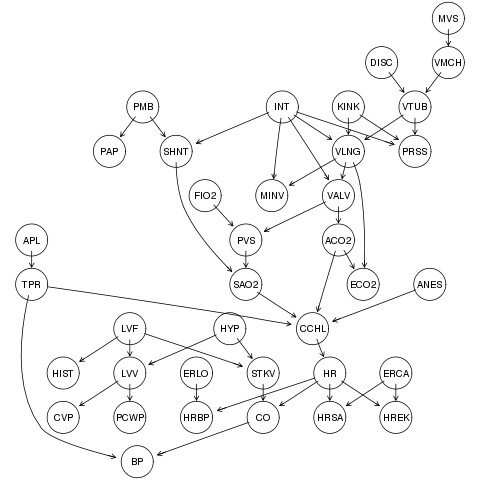

In [37]:
display_png(file="figures/ALARM.png", width = 10*h, height =10*h )

In [20]:
# CORRECT DAG
data(alarm)
modelstring = paste0("[HIST|LVF][CVP|LVV][PCWP|LVV][HYP][LVV|HYP:LVF][LVF]",
  "[STKV|HYP:LVF][ERLO][HRBP|ERLO:HR][HREK|ERCA:HR][ERCA][HRSA|ERCA:HR][ANES]",
  "[APL][TPR|APL][ECO2|ACO2:VLNG][KINK][MINV|INT:VLNG][FIO2][PVS|FIO2:VALV]",
  "[SAO2|PVS:SHNT][PAP|PMB][PMB][SHNT|INT:PMB][INT][PRSS|INT:KINK:VTUB][DISC]",
  "[MVS][VMCH|MVS][VTUB|DISC:VMCH][VLNG|INT:KINK:VTUB][VALV|INT:VLNG]",
  "[ACO2|VALV][CCHL|ACO2:ANES:SAO2:TPR][HR|CCHL][CO|HR:STKV][BP|CO:TPR]")
dag = model2network(modelstring)

In [38]:
#qgraph(dag, nodeNames = names(dag$nodes), legend=FALSE)

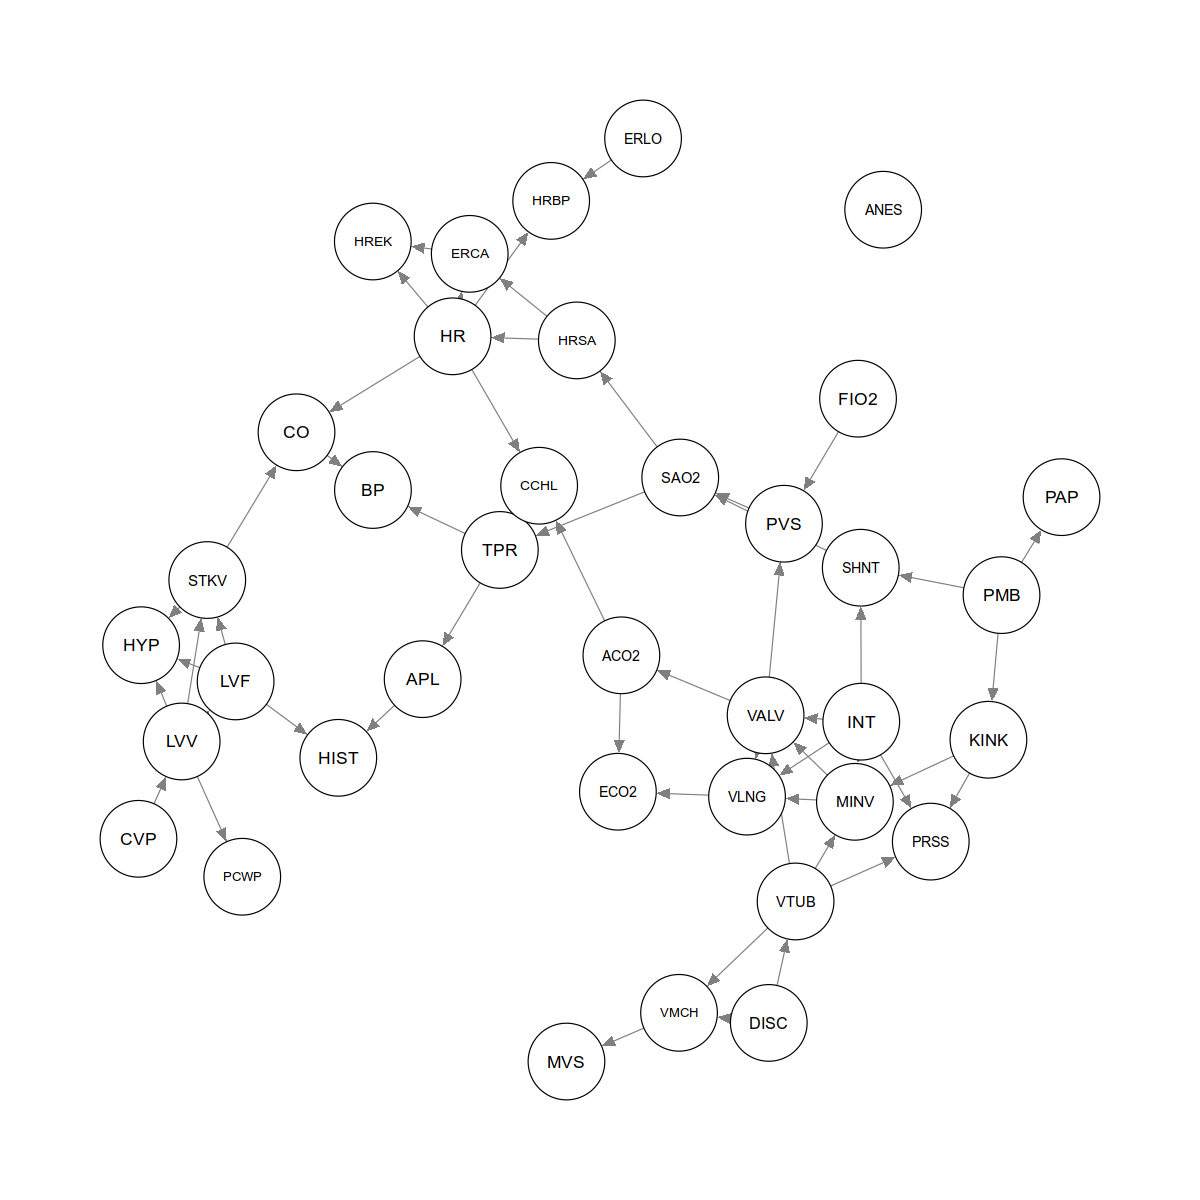

In [30]:
df.D <- data.frame(apply(alarm <- as.data.frame(alarm),c(1,2),as.character), stringsAsFactors = TRUE)

net <- hc(df.D, score = 'k2', maxp = 4)

#fit <- bn.fit(net, data = df.D, method = 'bayes')
qgraph(net, palette="colorblind")

Node:  CVP 	-> Parents of  CVP :   
Node:  PCWP 	-> Parents of  PCWP :  CVP 
Node:  HIST 	-> Parents of  HIST :  CVP PCWP 
Node:  TPR 	-> Parents of  TPR :   
Node:  BP 	-> Parents of  BP :  HIST PCWP TPR 
Node:  CO 	-> Parents of  CO :  HIST PCWP TPR BP 
Node:  HRBP 	-> Parents of  HRBP :  HIST TPR CO 
Node:  HREK 	-> Parents of  HREK :  TPR CO HRBP 
Node:  HRSA 	-> Parents of  HRSA :  CO HRBP HREK 
Node:  PAP 	-> Parents of  PAP :   
Node:  SAO2 	-> Parents of  SAO2 :  TPR HRBP 
Node:  FIO2 	-> Parents of  FIO2 :  SAO2 
Node:  PRSS 	-> Parents of  PRSS :  SAO2 
Node:  ECO2 	-> Parents of  ECO2 :  FIO2 PRSS SAO2 
Node:  MINV 	-> Parents of  MINV :  PRSS ECO2 SAO2 
Node:  MVS 	-> Parents of  MVS :  ECO2 PRSS MINV 
Node:  HYP 	-> Parents of  HYP :  CVP CO PCWP 
Node:  LVF 	-> Parents of  LVF :  CO PCWP HIST 
Node:  APL 	-> Parents of  APL :  TPR 
Node:  ANES 	-> Parents of  ANES :   
Node:  PMB 	-> Parents of  PMB :  SAO2 PAP 
Node:  INT 	-> Parents of  INT :  PRSS ECO2 MINV 
Node:  KIN

$score
[1] -226210.8

$dag

  Random/Generated Bayesian network

  model:
   [CVP][TPR][PAP][ANES][PCWP|CVP][APL|TPR][HIST|CVP:PCWP][BP|PCWP:HIST:TPR]
   [CO|PCWP:HIST:TPR:BP][HRBP|HIST:TPR:CO][HYP|CVP:PCWP:CO][LVF|PCWP:HIST:CO]
   [HREK|TPR:CO:HRBP][SAO2|TPR:HRBP][LVV|CVP:PCWP:HYP:LVF][HRSA|CO:HRBP:HREK]
   [FIO2|SAO2][PRSS|SAO2][PMB|PAP:SAO2][STKV|CO:HRBP:LVF:LVV]
   [ECO2|SAO2:FIO2:PRSS][CCHL|TPR:HRBP:HREK:HRSA][HR|CO:HRBP:HREK:STKV]
   [MINV|SAO2:PRSS:ECO2][ERLO|CO:HRBP:HREK:CCHL][ERCA|HREK:HRSA:HR]
   [MVS|PRSS:ECO2:MINV][INT|PRSS:ECO2:MINV][KINK|PRSS:MINV:INT]
   [DISC|PRSS:MINV:MVS:INT][SHNT|SAO2:MINV:PMB:INT][PVS|SAO2:MINV:INT:SHNT]
   [VTUB|PRSS:MINV:MVS:DISC][ACO2|ECO2:MINV:INT:PVS][VALV|ECO2:MINV:INT:PVS]
   [VMCH|MVS:DISC:VTUB][VLNG|ECO2:INT:ACO2:VALV]
  nodes:                                 37 
  arcs:                                  101 
    undirected arcs:                     0 
    directed arcs:                       101 
  average markov blanket size:           6.5

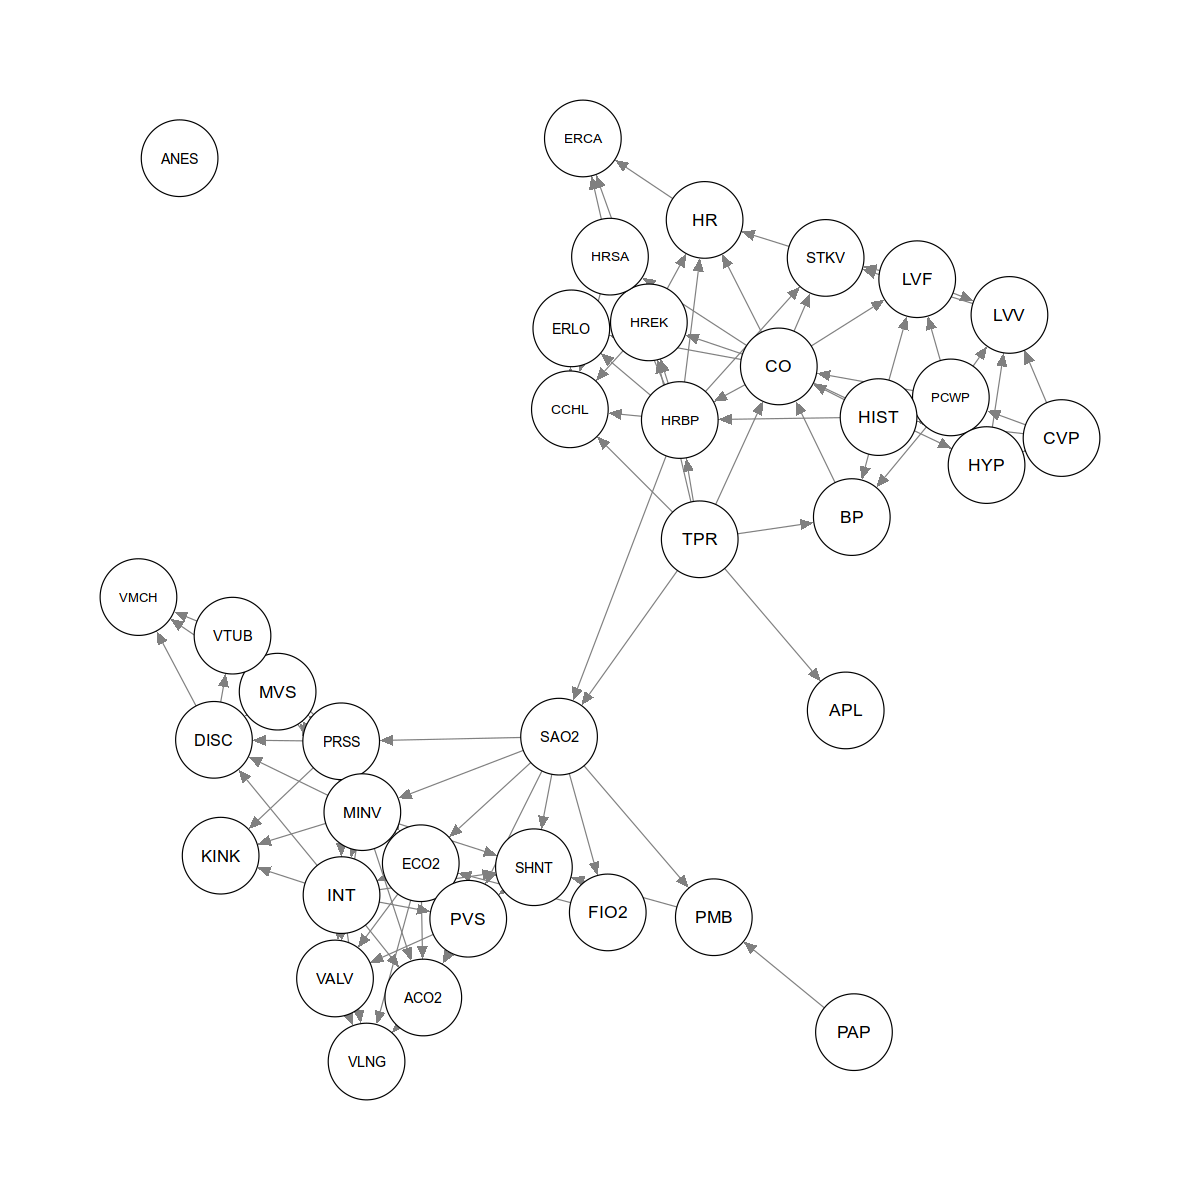

In [22]:
alarm <- as.data.frame(alarm)
K2(data = alarm, order = c(1:length(alarm)), max.parent=4, cases.column=FALSE, f=score.log,output.prob=FALSE)

## 6. Computation time<a class="anchor" id="comptime"></a>

In [35]:
time <- function(fun){
    start <- Sys.time()
    capture.output(fun)
    end   <- Sys.time()
    return(round(end - start,2))
}

In [47]:
data = Child

cas <- seq(from = 100, to = nrow(data), by = 500)

n <- length(cas)
ts <- double(n)
for (i in 1:n){
    ci <- cas[i]
    ts[[i]] <- time(K2(data[1:ci,],cases.column = FALSE, order = c(1:length(data)), output.prob = FALSE, f = score.log, output.graph = FALSE, max.parents = 2 ))
}

dt <- data.table(cas, ts)

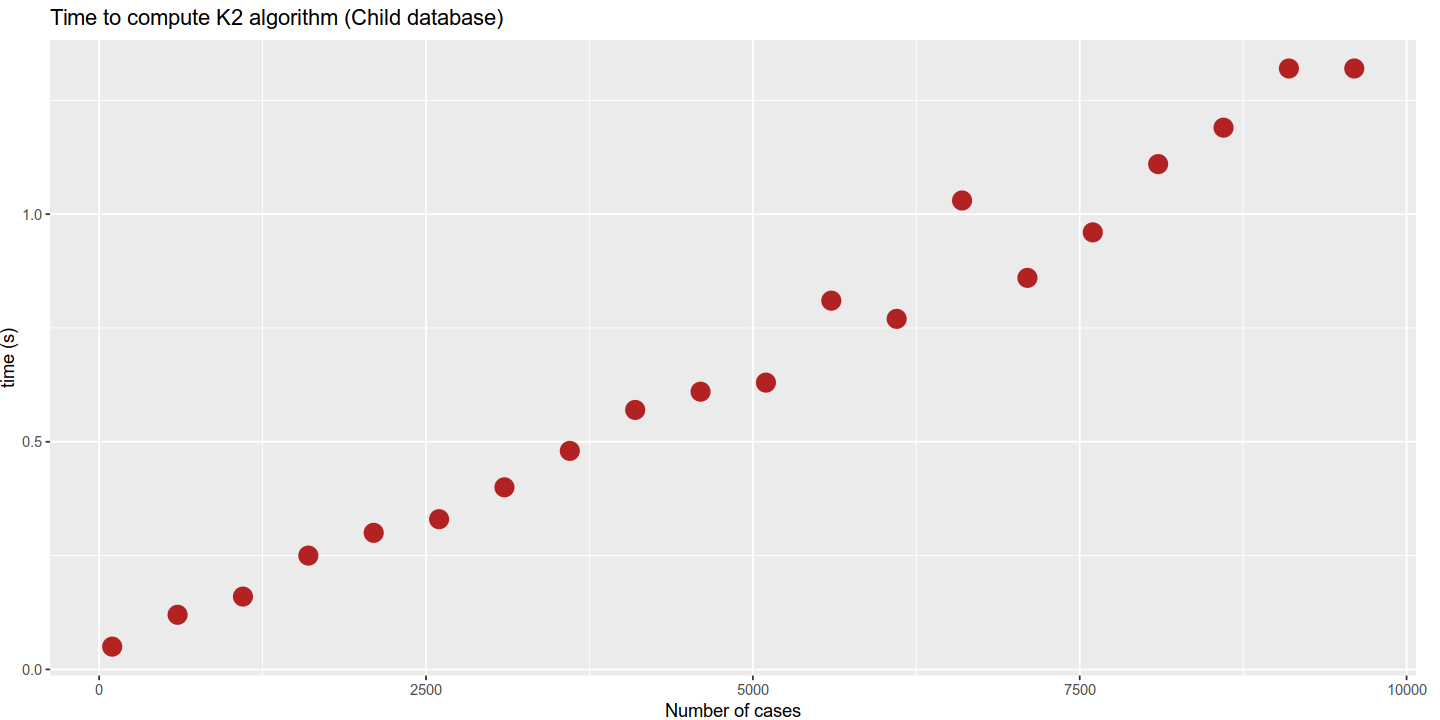

In [53]:
options(repr.plot.width=12, repr.plot.height=6)

ggplot(dt, aes(x=cas, y=ts)) + geom_point(color='firebrick', size = 5) +
labs(title='Time to compute K2 algorithm (Child database)', x='Number of cases', y='time (s)') +
theme(plot.margin = margin(.2, .5, 0, 0, 'cm'))


## Conclusions<a class="anchor" id="conclusions"></a>

We implemented the code for the K2 algorithm for the inference of the structure of a Bayesian Network, and we applied it to several databases of different dimensions.

The results are incouraging for small databases, but becoming larger we can see growing problems.

In any case we observe an issue with this K2 algorithm: it depends on the ordering of the nodes. This is a weak point, since in case we don't know in the beginning the structure of the network it can lead to a challenging task.

### Bibliography<a class="anchor" id="biblio"></a>
[1]<a class="anchor" id="1"></a> M. Scutari and J. B. Denis, Bayesian Networks, CRC Press, 2022, Taylor and Francis Group.

[2]<a class="anchor" id="2"></a> G. F. Cooper and E. Herskovits, A Bayesian Method for the Induction of Probabilistic Networks from Data, Machine Learning 9, (1992) 309

[3]<a class="anchor" id="3"></a> C. Ruiz, Illustration of the K2 Algorithm for learning Bayes Net Structures, http://web.cs.wpi.edu/~cs539/s11/Projects/k2_algorithm.pdf

[4]<a class="anchor" id="4"></a> A. Franzin et al., bnstruct: an R package for Bayesian Network structure learning in the presence of missing data, Bioinformatics 33(8) (2017) 1250

[5]<a class="anchor" id="5"></a> F. Sambo and A. Franzin, bnstruct: an R package for Bayesian Network Structure Learning with
missing data, December 12, 2016